## Datasets download and preparation

### UTKFace

In [ ]:
!pip install gdown

In [ ]:
!gdown "https://drive.google.com/uc?id=1mb5Z24TsnKI3ygNIlX6ZFiwUj0_PmpAW&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1mb5Z24TsnKI3ygNIlX6ZFiwUj0_PmpAW&confirm=t
To: /content/part1.tar.gz
100% 874M/874M [00:08<00:00, 103MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=19vdaXVRtkP-nyxz1MYwXiFsh_m_OL72b&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=19vdaXVRtkP-nyxz1MYwXiFsh_m_OL72b&confirm=t
To: /content/part2.tar.gz
100% 459M/459M [00:05<00:00, 78.2MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=1oj9ZWsLV2-k2idoW_nRSrLQLUP3hus3b&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1oj9ZWsLV2-k2idoW_nRSrLQLUP3hus3b&confirm=t
To: /content/part3.tar.gz
100% 57.0M/57.0M [00:00<00:00, 57.1MB/s]


In [ ]:
!tar -xzf part1.tar.gz
!tar -xzf part2.tar.gz
!tar -xzf part3.tar.gz

In [ ]:
import os
from tqdm import tqdm
from PIL import Image
import copy
from torchvision import transforms

imgs = []
attributes = []

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

for img_path, file_name in tqdm([(os.path.join(part, f), f) for part in ['part1', 'part2', 'part3'] for f in os.listdir(part)]):
    if file_name.endswith('.jpg'):
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        age, gender = file_name.split('_')[0], file_name.split('_')[1]
        try:
            attrib = (float(age), int(gender))
        except:
            attrib = (float(age), 1) # there is one file without gender with female photo in the dataset

        if attrib[1] not in (0, 1):
           continue
        attributes.append(attrib)
        imgs.append(transform(img))

100%|██████████| 24109/24109 [02:32<00:00, 157.79it/s]


In [ ]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms

class UTKFaceDataset(Dataset):
    def __init__(self, imgs, attributes, transform=None, device='cpu'):
        self.imgs = imgs
        self.attributes = attributes
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = self.transform(img)
        return img.to(self.device), torch.tensor(self.attributes[idx]).to(self.device)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

x_train, x_test, y_train, y_test = train_test_split(imgs, attributes, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

train_dataset = UTKFaceDataset(x_train, y_train, None, device)
val_dataset = UTKFaceDataset(x_val, y_val, None, device)
test_dataset = UTKFaceDataset(x_test, y_test, None, device)

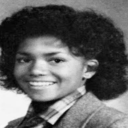

tensor([24.,  1.], device='cuda:0')


In [ ]:
from torchvision.transforms import ToPILImage

display(ToPILImage()(train_dataset.__getitem__(0)[0]))
print(train_dataset.__getitem__(0)[1])

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Sliding window CNN face feature model

In [ ]:
import torch.nn.functional as F
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

class ResNet(nn.Module):
        def __init__(self, block, layers):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.gender_head = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
            self.age_head = nn.Linear(512, 1)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            return self.gender_head(x), self.age_head(x)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_shape=(3, 128, 128)):
        super(CNNModel, self).__init__()
        channels = 64
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, 1, kernel_size=1),
            nn.ReLU(),
        )

        # binary classification
        self.gender_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[1] * input_shape[2], 1),
            nn.Sigmoid()
        )
        # regression
        self.age_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[1] * input_shape[2], 1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        gender_logits = self.gender_head(x)
        age_output = self.age_head(x)
        return gender_logits, age_output

In [ ]:
import torch.optim as optim

model = ResNet(ResidualBlock, [3, 4, 6, 3])
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
gender_criterion = nn.BCELoss()
age_criterion = nn.MSELoss()

In [ ]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,472
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
    ResidualBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
from tqdm import tqdm

def train(model, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for images, attributes in tqdm(train_loader):
            images = images
            age_labels = attributes[:, 0]
            gender_labels = attributes[:, 1]

            optimizer.zero_grad()

            gender_logits, age_output = model(images)

            gender_loss = gender_criterion(gender_logits.squeeze(), gender_labels)
            age_loss = age_criterion(age_output.squeeze(), age_labels)

            loss = gender_loss + age_loss
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0.0
        gender_correct = 0
        age_mae_total = 0
        with torch.no_grad():
            for images, attributes in val_loader:
                age_labels = attributes[:, 0]
                gender_labels = attributes[:, 1]

                gender_logits, age_output = model(images)

                gender_loss = gender_criterion(gender_logits.squeeze(), gender_labels)
                age_loss = age_criterion(age_output.squeeze(), age_labels)
                loss = gender_loss + age_loss
                total_val_loss += loss.item()

                gender_correct += ((gender_logits.squeeze() >= 0.5) == gender_labels).sum().item()
                age_mae_total += torch.abs(age_output.squeeze() - age_labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_gender_acc = gender_correct / len(val_dataset)
        val_age_mae = age_mae_total / len(val_dataset)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Val Gender Accuracy: {val_gender_acc*100:.2f}% | Val Age MAE: {val_age_mae:.2f}")

In [ ]:
train(model, 50)

100%|██████████| 302/302 [00:33<00:00,  8.93it/s]


Epoch 1/50
Train Loss: 350.2232 | Val Loss: 357.1032
Val Gender Accuracy: 59.96% | Val Age MAE: 14.08


100%|██████████| 302/302 [00:34<00:00,  8.82it/s]


Epoch 2/50
Train Loss: 328.1128 | Val Loss: 327.3071
Val Gender Accuracy: 59.25% | Val Age MAE: 13.78


100%|██████████| 302/302 [00:35<00:00,  8.50it/s]


Epoch 3/50
Train Loss: 301.7620 | Val Loss: 313.1772
Val Gender Accuracy: 61.16% | Val Age MAE: 13.09


100%|██████████| 302/302 [00:35<00:00,  8.62it/s]


Epoch 4/50
Train Loss: 280.8977 | Val Loss: 292.6776
Val Gender Accuracy: 50.29% | Val Age MAE: 12.87


100%|██████████| 302/302 [00:34<00:00,  8.65it/s]


Epoch 5/50
Train Loss: 249.4148 | Val Loss: 285.6533
Val Gender Accuracy: 64.07% | Val Age MAE: 13.18


100%|██████████| 302/302 [00:34<00:00,  8.67it/s]


Epoch 6/50
Train Loss: 226.7508 | Val Loss: 287.8608
Val Gender Accuracy: 61.87% | Val Age MAE: 12.65


100%|██████████| 302/302 [00:35<00:00,  8.62it/s]


Epoch 7/50
Train Loss: 205.3643 | Val Loss: 254.2558
Val Gender Accuracy: 62.82% | Val Age MAE: 12.30


100%|██████████| 302/302 [00:34<00:00,  8.67it/s]


Epoch 8/50
Train Loss: 185.7563 | Val Loss: 287.5523
Val Gender Accuracy: 62.70% | Val Age MAE: 13.37


100%|██████████| 302/302 [00:34<00:00,  8.64it/s]


Epoch 9/50
Train Loss: 173.2720 | Val Loss: 243.6548
Val Gender Accuracy: 62.16% | Val Age MAE: 11.42


100%|██████████| 302/302 [00:34<00:00,  8.69it/s]


Epoch 10/50
Train Loss: 157.3958 | Val Loss: 270.5199
Val Gender Accuracy: 61.95% | Val Age MAE: 12.00


100%|██████████| 302/302 [00:34<00:00,  8.66it/s]


Epoch 11/50
Train Loss: 140.7434 | Val Loss: 246.8592
Val Gender Accuracy: 64.56% | Val Age MAE: 10.80


100%|██████████| 302/302 [00:34<00:00,  8.67it/s]


Epoch 12/50
Train Loss: 119.5598 | Val Loss: 275.3731
Val Gender Accuracy: 52.61% | Val Age MAE: 11.81


100%|██████████| 302/302 [00:34<00:00,  8.67it/s]


Epoch 13/50
Train Loss: 102.7664 | Val Loss: 232.6708
Val Gender Accuracy: 57.47% | Val Age MAE: 11.32


100%|██████████| 302/302 [00:34<00:00,  8.66it/s]


Epoch 14/50
Train Loss: 81.2860 | Val Loss: 231.9572
Val Gender Accuracy: 65.68% | Val Age MAE: 10.67


100%|██████████| 302/302 [00:34<00:00,  8.65it/s]


Epoch 15/50
Train Loss: 67.5411 | Val Loss: 189.1827
Val Gender Accuracy: 65.85% | Val Age MAE: 9.62


100%|██████████| 302/302 [00:34<00:00,  8.67it/s]


Epoch 16/50
Train Loss: 50.5840 | Val Loss: 193.2504
Val Gender Accuracy: 67.05% | Val Age MAE: 9.67


100%|██████████| 302/302 [00:34<00:00,  8.65it/s]


Epoch 17/50
Train Loss: 38.6551 | Val Loss: 398.8492
Val Gender Accuracy: 61.99% | Val Age MAE: 14.88


100%|██████████| 302/302 [00:34<00:00,  8.70it/s]


Epoch 18/50
Train Loss: 32.3139 | Val Loss: 167.7563
Val Gender Accuracy: 69.21% | Val Age MAE: 9.13


100%|██████████| 302/302 [00:34<00:00,  8.67it/s]


Epoch 19/50
Train Loss: 28.1714 | Val Loss: 281.0219
Val Gender Accuracy: 67.51% | Val Age MAE: 12.65


100%|██████████| 302/302 [00:34<00:00,  8.67it/s]


Epoch 20/50
Train Loss: 23.3560 | Val Loss: 177.6021
Val Gender Accuracy: 69.38% | Val Age MAE: 9.40


100%|██████████| 302/302 [00:34<00:00,  8.65it/s]


Epoch 21/50
Train Loss: 19.5888 | Val Loss: 177.3235
Val Gender Accuracy: 69.54% | Val Age MAE: 9.36


100%|██████████| 302/302 [00:34<00:00,  8.68it/s]


Epoch 22/50
Train Loss: 17.2121 | Val Loss: 169.0479
Val Gender Accuracy: 69.92% | Val Age MAE: 9.19


100%|██████████| 302/302 [00:34<00:00,  8.70it/s]


Epoch 23/50
Train Loss: 17.3748 | Val Loss: 178.5039
Val Gender Accuracy: 69.25% | Val Age MAE: 9.16


100%|██████████| 302/302 [00:34<00:00,  8.70it/s]


Epoch 24/50
Train Loss: 16.6543 | Val Loss: 181.3378
Val Gender Accuracy: 71.87% | Val Age MAE: 9.30


100%|██████████| 302/302 [00:34<00:00,  8.68it/s]


Epoch 25/50
Train Loss: 16.6935 | Val Loss: 285.2869
Val Gender Accuracy: 69.21% | Val Age MAE: 12.30


 34%|███▍      | 103/302 [00:12<00:23,  8.57it/s]


KeyboardInterrupt: 

In [ ]:
def test(model, test_loader):
    model.eval()
    gender_correct = 0
    age_mae_total = 0
    with torch.no_grad():
        for images, attributes in test_loader:
            age_labels = attributes[:, 0]
            gender_labels = attributes[:, 1]

            gender_logits, age_output = model(images)

            gender_correct += ((gender_logits.squeeze() >= 0.5) == gender_labels).sum().item()
            age_mae_total += torch.abs(age_output.squeeze() - age_labels).sum().item()

    val_gender_acc = gender_correct / len(val_dataset)
    val_age_mae = age_mae_total / len(val_dataset)

    print(f"Val Gender Accuracy: {val_gender_acc*100:.2f}% | Val Age MAE: {val_age_mae:.2f}")

In [ ]:
test(model, test_loader)

Val Gender Accuracy: 71.99% | Val Age MAE: 9.14


In [ ]:
torch.save(model.state_dict(), 'resnet_72percent_9_14_mae.pth')

## Sliding window CNN face detector

### WIDERFace dataset

In [ ]:
!wget https://huggingface.co/datasets/CUHK-CSE/wider_face/resolve/main/data/WIDER_train.zip
!wget https://huggingface.co/datasets/CUHK-CSE/wider_face/resolve/main/data/WIDER_val.zip
!wget https://huggingface.co/datasets/CUHK-CSE/wider_face/resolve/main/data/WIDER_test.zip
!wget http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

!unzip WIDER_train.zip
!unzip WIDER_val.zip
!unzip WIDER_test.zip
!unzip wider_face_split.zip

Streaming output truncated to the last 5000 lines.
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_347.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_354.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_358.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_359.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_372.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_384.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_385.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_39.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_392.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_395.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_398.jpg  
  inflating: WIDER_test/images/44--Aerobics/44_Aerobics_Aerobics_44_401.jpg  
  inflating: W

In [ ]:
from torch.utils.data import Dataset
import torch
from PIL import Image
import os

class WIDERFaceDataset(Dataset):
    def __init__(self, images_dir, annotation_file, transform=None, use_attributes=False):
        self.images_dir = images_dir
        self.transform = transform
        self.use_attributes = use_attributes
        self.samples = self._parse_annotation_file(annotation_file)

    def _parse_annotation_file(self, annotation_file):
        samples = []
        with open(annotation_file, 'r') as f:
            lines = f.readlines()

        i = 0
        while i < len(lines):
            image_rel_path = lines[i].strip()
            i += 1
            if i >= len(lines):
                break

            try:
                num_faces = int(lines[i].strip())
            except ValueError:
                print(f"Warning: expected number of faces at line {i}, got: {lines[i]}")
                break
            i += 1

            boxes = []
            attributes = []

            for _ in range(num_faces):
                if i >= len(lines):
                    break
                parts = list(map(int, lines[i].strip().split()))
                if len(parts) < 10:
                    i += 1
                    continue  # skip malformed
                x, y, w, h = parts[:4]
                attr = {
                    "blur": parts[4],
                    "expression": parts[5],
                    "illumination": parts[6],
                    "invalid": parts[7],
                    "occlusion": parts[8],
                    "pose": parts[9],
                }
                i += 1

                if w <= 0 or h <= 0 or attr["invalid"] == 1:
                    continue

                boxes.append([x, y, x + w, y + h])
                if self.use_attributes:
                    attributes.append(attr)

            samples.append((image_rel_path, boxes, attributes if self.use_attributes else None))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_rel_path, boxes, attributes = self.samples[idx]
        img_path = os.path.join(self.images_dir, image_rel_path)
        image = Image.open(img_path).convert("RGB")

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.ones((len(boxes),), dtype=torch.int64),
        }

        if self.use_attributes and attributes is not None:
            for attr_name in ['blur', 'expression', 'illumination', 'occlusion', 'pose']:
                target[attr_name] = torch.tensor(
                    [attr[attr_name] for attr in attributes], dtype=torch.int64
                )

        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
import matplotlib.pyplot as plt

def display_image_with_boxes(img, detections):
    if isinstance(img, torch.Tensor):
        img_pil = transforms.ToPILImage()(img.cpu())
    else:
        img_pil = img

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_pil)

    if isinstance(detections, dict) and 'boxes' in detections:
        boxes_to_draw = detections['boxes']
        annotations_present = False # Annotations are not in this format
    # Check if detections is the list of results from the pipeline
    elif isinstance(detections, list) and all(isinstance(d, dict) and 'bbox' in d for d in detections):
        boxes_to_draw = [torch.tensor(d['bbox']) for d in detections]
        annotations_present = 'age' in detections[0] and 'gender' in detections[0]
    else:
        print("Warning: Unexpected format for detections.")
        boxes_to_draw = []
        annotations_present = False


    for i, box in enumerate(boxes_to_draw):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add text annotation if attributes are present and detections is from the pipeline
        if annotations_present and isinstance(detections, list):
             detection = detections[i] # Get the corresponding detection dictionary
             age = detection.get('age', 'N/A')
             gender = detection.get('gender', 'N/A')
             text = f"Age: {age}\nGender: {gender}"
             ax.text(box[2] + 5, box[1], text, color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.5), verticalalignment='top') # Adjust position and alignment


    ax.axis('off')
    fig.tight_layout(pad=0)
    ax.margins(0)

    plt.show()

In [ ]:
from torchvision import transforms

wider_dataset = WIDERFaceDataset(
    images_dir='WIDER_train/images',
    annotation_file='wider_face_split/wider_face_train_bbx_gt.txt',
    transform=transforms.ToTensor(),
    use_attributes=True
)
img, target = wider_dataset[0]
print(img.shape)
print(target['boxes'].shape)
print(len(wider_dataset))


torch.Size([3, 1385, 1024])
torch.Size([1, 4])
280


In [ ]:
import random
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

resize = transforms.Resize((128, 128))

class FaceDetectionDataset(Dataset):
    def __init__(self, wider_dataset, transform=None, neg_samples_per_img=3, patch_size=(128, 128), box_scale=1.5):
        self.wider_dataset = wider_dataset
        self.transform = transform
        self.neg_samples_per_img = neg_samples_per_img
        self.patch_size = patch_size
        self.box_scale = box_scale
        self.samples = self._generate_samples()

    def _generate_samples(self):
        samples = []
        for img_idx in tqdm(range(len(self.wider_dataset))):
            img, target = self.wider_dataset[img_idx]
            boxes = target['boxes']

            for box in boxes:
                x1, y1, x2, y2 = [int(b) for b in box]
                w, h = int(1.5 * abs(x2 - x1)), int(1.5 * abs(y2 - y1))
                x_center, y_center = int((x1 + x2) / 2), int((y1 + y2) / 2)
                x, y = int(x_center -  w / 2), int(y_center - h / 2)
                patch = F.crop(img, y, x, h, w)
                samples.append((resize(patch), 1))

            # Negative samples
            img_w, img_h = img.shape[1], img.shape[2]
            for _ in range(self.neg_samples_per_img):
                is_overlapping = True
                attempts = 0
                max_attempts = 100
                while is_overlapping and attempts < max_attempts:
                    if img_w < self.patch_size[0] or img_h < self.patch_size[1]:
                        break

                    x = random.randint(0, img_w - self.patch_size[0])
                    y = random.randint(0, img_h - self.patch_size[1])
                    negative_box = torch.tensor([x, y, x + self.patch_size[0], y + self.patch_size[1]], dtype=torch.float32)

                    is_overlapping = False
                    for box in boxes:
                        if not (negative_box[2] < box[0] or negative_box[0] > box[2] or negative_box[3] < box[1] or negative_box[1] > box[3]):
                            is_overlapping = True
                            break
                    attempts += 1

                if not is_overlapping:
                    patch = F.crop(img, y, x, self.patch_size[1], self.patch_size[0])
                    samples.append((patch, 0))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        patch, label = self.samples[idx]
        if self.transform:
            if isinstance(patch, Image.Image):
                 patch = transforms.ToTensor()(patch)
            patch = self.transform(patch)
        elif isinstance(patch, Image.Image):
             patch = transforms.ToTensor()(patch)

        return patch, torch.tensor(label, dtype=torch.float32)

In [ ]:
detection_training_dataset = FaceDetectionDataset(wider_dataset, neg_samples_per_img=80)

100%|██████████| 280/280 [00:25<00:00, 10.85it/s]


In [ ]:
import gc
gc.collect()

0

In [ ]:
len(detection_training_dataset)

31892

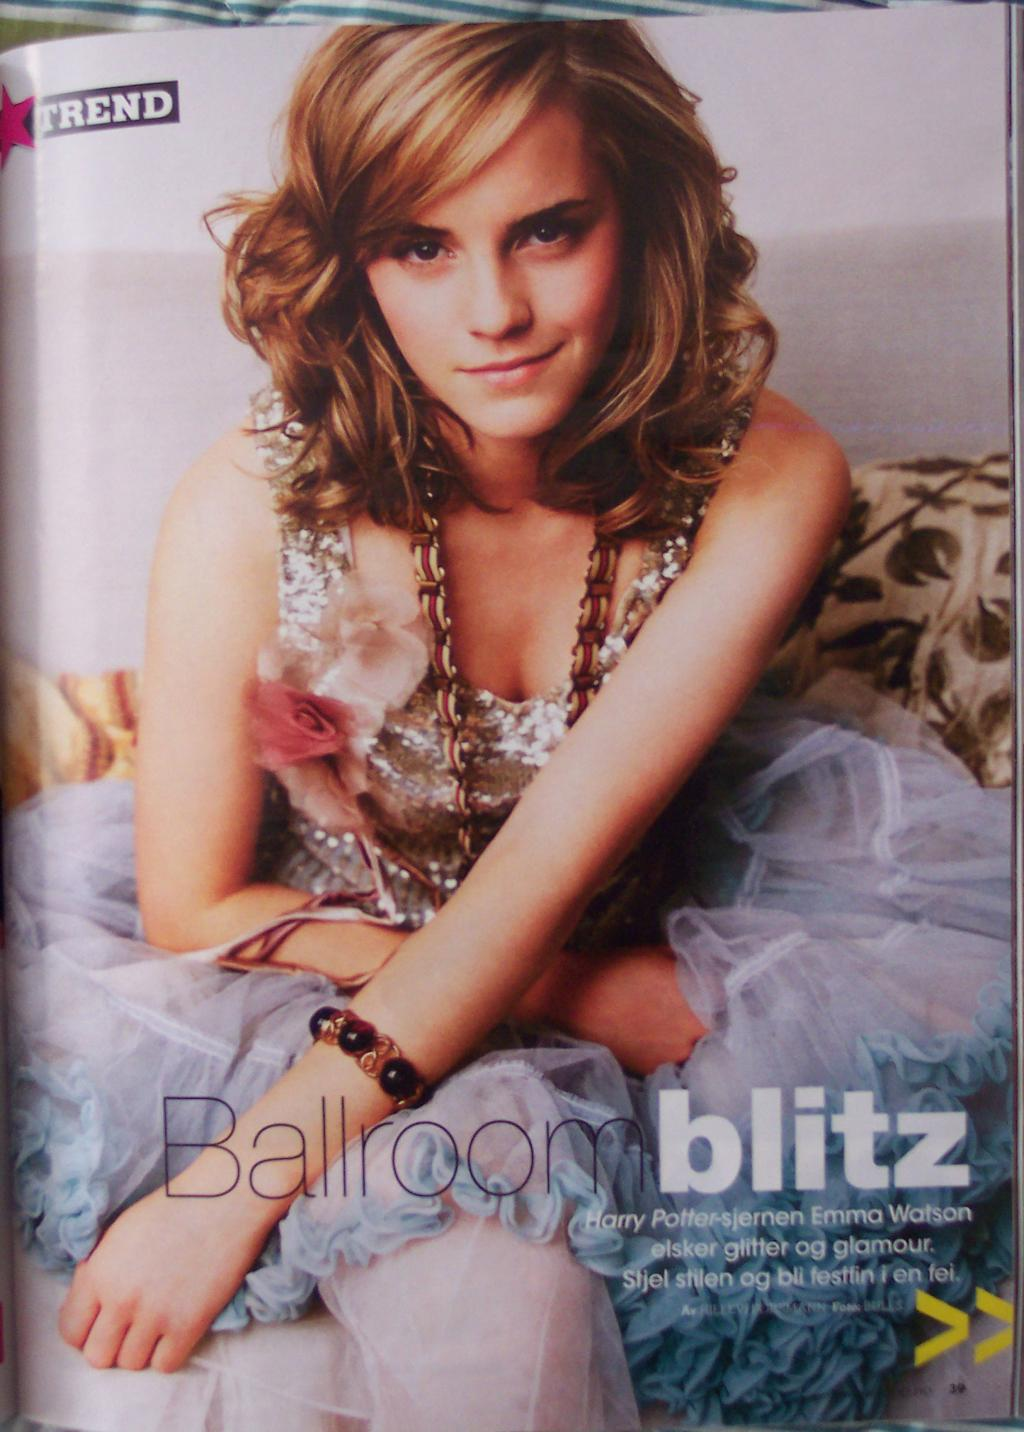

In [ ]:
display(transforms.ToPILImage()(wider_dataset[1][0]))

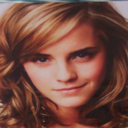

In [ ]:
display(transforms.ToPILImage()(detection_training_dataset[81][0]))

In [ ]:
detection_training_dataset[81][0].shape

torch.Size([3, 128, 128])

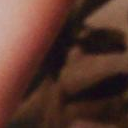

In [ ]:
display(transforms.ToPILImage()(detection_training_dataset[83][0]))

In [ ]:
detection_training_dataset[81][1], detection_training_dataset[83][1]

(tensor(1.), tensor(0.))

In [ ]:
imgs = [elem[0].to(device) for elem in detection_training_dataset]
labels = [elem[1].to(device) for elem in detection_training_dataset]

In [ ]:
labels[1]

tensor(0., device='cuda:0')

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

train_dataset = TensorDataset(torch.stack(x_train), torch.stack(y_train))
val_dataset = TensorDataset(torch.stack(x_val), torch.stack(y_val))
test_dataset = TensorDataset(torch.stack(x_test), torch.stack(y_test))

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from torch import nn
import copy

class SlidingCNNDetectorModel(nn.Module):
    def __init__(self, classifier):
        super(SlidingCNNDetectorModel, self).__init__()
        self.features = nn.Sequential(
          copy.deepcopy(classifier.conv1),
          copy.deepcopy(classifier.maxpool),
          copy.deepcopy(classifier.layer0),
          copy.deepcopy(classifier.layer1),
          copy.deepcopy(classifier.layer2),
          copy.deepcopy(classifier.layer3),
          copy.deepcopy(classifier.avgpool))

        self.detector = nn.Sequential(
          nn.Flatten(),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(256, 1),
          nn.Sigmoid())

    def forward(self, x):
      x = self.features(x)
      return self.detector(x)

In [ ]:
face_feature_model = ResNet(ResidualBlock, [3, 4, 6, 3])
face_feature_model.load_state_dict(torch.load('resnet_72percent_9_14_mae.pth', weights_only=True))
face_feature_model.eval()
face_feature_model.to(device)
None

In [ ]:
def train_detector(model, num_epochs, train_loader, val_loader):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()

            pred = model(images)
            loss = criterion(pred.squeeze(), labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                val_pred = model(images)
                loss = criterion(val_pred.squeeze(), labels)
                total_val_loss += loss.item()

                correct += ((val_pred >= 0.5).squeeze() == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = correct / len(val_dataset)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc*100:.2f}%")

In [ ]:
import torch.optim as optim

face_detector_model = SlidingCNNDetectorModel(face_feature_model).to(device)
optimizer = optim.Adam(face_detector_model.parameters(), lr=1e-2)
criterion = nn.BCELoss()

In [ ]:
face_detector_model.load_state_dict(torch.load('face_detector_weights.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
train_detector(face_detector_model, 10, train_loader, val_loader)

100%|██████████| 399/399 [00:44<00:00,  8.93it/s]


Epoch 1/10
Train Loss: 0.0798 | Val Loss: 0.3406
Val Accuracy: 89.87%


100%|██████████| 399/399 [00:44<00:00,  8.98it/s]


Epoch 2/10
Train Loss: 0.0399 | Val Loss: 0.0742
Val Accuracy: 98.31%


100%|██████████| 399/399 [00:44<00:00,  8.95it/s]


Epoch 3/10
Train Loss: 0.0398 | Val Loss: 0.1813
Val Accuracy: 94.76%


100%|██████████| 399/399 [00:44<00:00,  8.99it/s]


Epoch 4/10
Train Loss: 0.0231 | Val Loss: 0.0408
Val Accuracy: 98.78%


100%|██████████| 399/399 [00:44<00:00,  8.99it/s]


Epoch 5/10
Train Loss: 0.0207 | Val Loss: 0.0388
Val Accuracy: 98.81%


100%|██████████| 399/399 [00:44<00:00,  9.00it/s]


Epoch 6/10
Train Loss: 0.0173 | Val Loss: 0.1057
Val Accuracy: 99.00%


100%|██████████| 399/399 [00:44<00:00,  9.01it/s]


Epoch 7/10
Train Loss: 0.0145 | Val Loss: 0.0310
Val Accuracy: 99.09%


100%|██████████| 399/399 [00:44<00:00,  9.03it/s]


Epoch 8/10
Train Loss: 0.0111 | Val Loss: 0.4310
Val Accuracy: 87.68%


100%|██████████| 399/399 [00:44<00:00,  9.02it/s]


Epoch 9/10
Train Loss: 0.0145 | Val Loss: 0.1176
Val Accuracy: 97.27%


100%|██████████| 399/399 [00:44<00:00,  9.05it/s]


Epoch 10/10
Train Loss: 0.0114 | Val Loss: 0.0433
Val Accuracy: 98.93%


In [ ]:
torch.save(face_detector_model.state_dict(), 'face_detector_weights.pth')

In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            pred = model(images)

            correct += ((pred >= 0.5).squeeze() == labels).sum().item()

    acc = correct / len(test_dataset)

    print(f"Accuracy: {acc*100:.2f}%")

In [ ]:
test(face_detector_model, test_loader)

Accuracy: 99.28%


In [ ]:
def nms(boxes, iou_threshold, conf_threshold):
    boxes = boxes[boxes[:, 4] >= conf_threshold]
    sorted_indices = torch.argsort(boxes[:, 4], descending=True)

    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    keep_indices = []

    while sorted_indices.numel() > 0:
        i = int(sorted_indices[0])
        keep_indices.append(i)

        if sorted_indices.numel() == 1:
            break

        sorted_indices = sorted_indices[1:]

        xx1 = torch.max(boxes[i, 0], boxes[sorted_indices, 0])
        yy1 = torch.max(boxes[i, 1], boxes[sorted_indices, 1])
        xx2 = torch.min(boxes[i, 2], boxes[sorted_indices, 2])
        yy2 = torch.min(boxes[i, 3], boxes[sorted_indices, 3])

        w = torch.clamp(xx2 - xx1, min=0)
        h = torch.clamp(yy2 - yy1, min=0)

        intersection = w * h
        iou = intersection / (areas[i] + areas[sorted_indices] - intersection)

        considered_indices = torch.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[considered_indices]

    return boxes[keep_indices]

In [ ]:
class SlidingWindowFaceDetector(nn.Module):
  def __init__(self, face_detector, face_classifier, target_size=(128, 128)):
    super(SlidingWindowFaceDetector, self).__init__()
    self.face_detector = face_detector
    self.face_classifier = face_classifier
    self.resize = transforms.Resize(target_size)
    self.face_shapes = [(32, 32), (48, 48), (80, 80), (128, 128), (256, 256)]

  def forward(self, img, iou_threshold=0.45, conf_threshold=0.75):
    probable_boxes = []

    img_h, img_w = img.shape[1], img.shape[2]

    for shape in self.face_shapes:
      for i in range(0, img_h, shape[0] // 4):
        for j in range(0, img_w, shape[1] // 4):
          patch_i_end = min(i + shape[0], img_h)
          patch_j_end = min(j + shape[1], img_w)

          if patch_i_end <= i or patch_j_end <= j:
            continue

          box_patch = img[:, i:patch_i_end, j:patch_j_end]
          conf = self.face_detector(self.resize(box_patch)[None, :])
          if conf >= conf_threshold:
            probable_boxes.append(torch.tensor((j, i, patch_j_end, patch_i_end, conf), device=device))

    if not probable_boxes:
        return []

    predicted_boxes = nms(torch.stack(probable_boxes), iou_threshold, conf_threshold)

    res = []
    for box in predicted_boxes:
        x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        face_patch = img[:, y1:y2, x1:x2]
        gender, age = self.face_classifier(self.resize(face_patch)[None, :])
        res.append({'bbox': box.cpu()[:4], 'gender': 'Female' if gender.item() >= 0.5 else 'Male', 'age': int(age.item())})
    return res

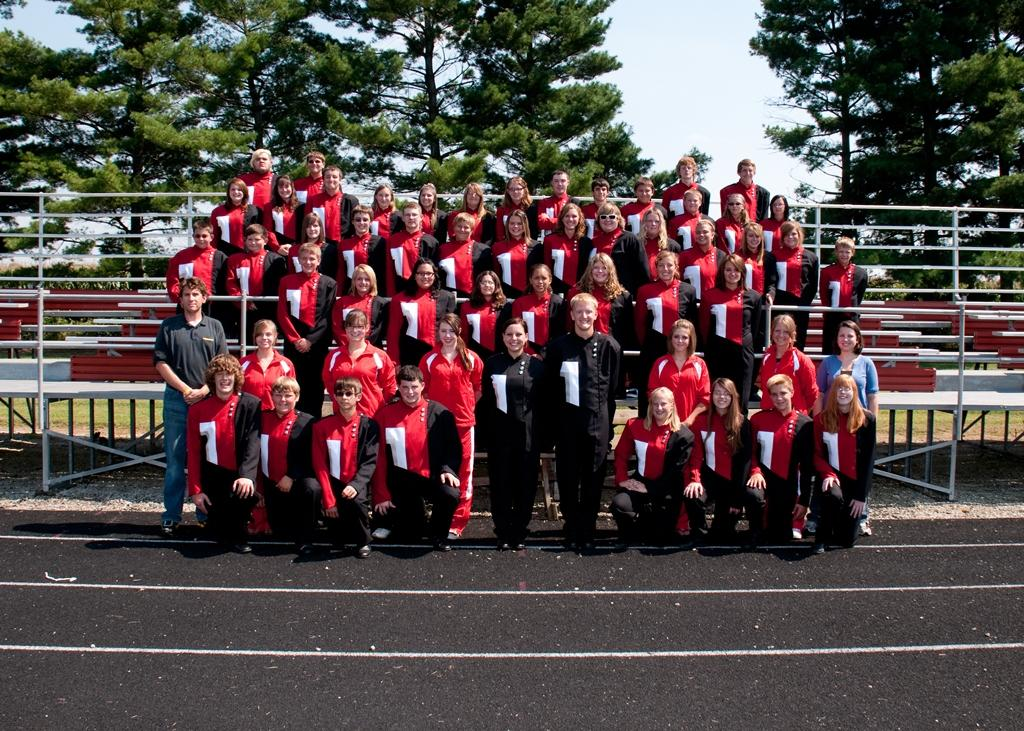

In [ ]:
img_path = '/content/WIDER_test/images/0--Parade/0_Parade_marchingband_1_47.jpg'
img = Image.open(img_path).convert('RGB')
display(img)

In [ ]:
sliding_window_model = SlidingWindowFaceDetector(face_detector_model, face_feature_model)

In [ ]:
tensor_img = transforms.ToTensor()(img)

In [ ]:
%time pred_boxes = sliding_window_model.forward(tensor_img.to(device), iou_threshold=0.1, conf_threshold=0.9999999999995)

CPU times: user 2min 6s, sys: 232 ms, total: 2min 6s
Wall time: 2min 7s


In [ ]:
len(pred_boxes)

54

/tmp/ipython-input-23-1336495720.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_to_draw = [torch.tensor(d['bbox']) for d in detections]


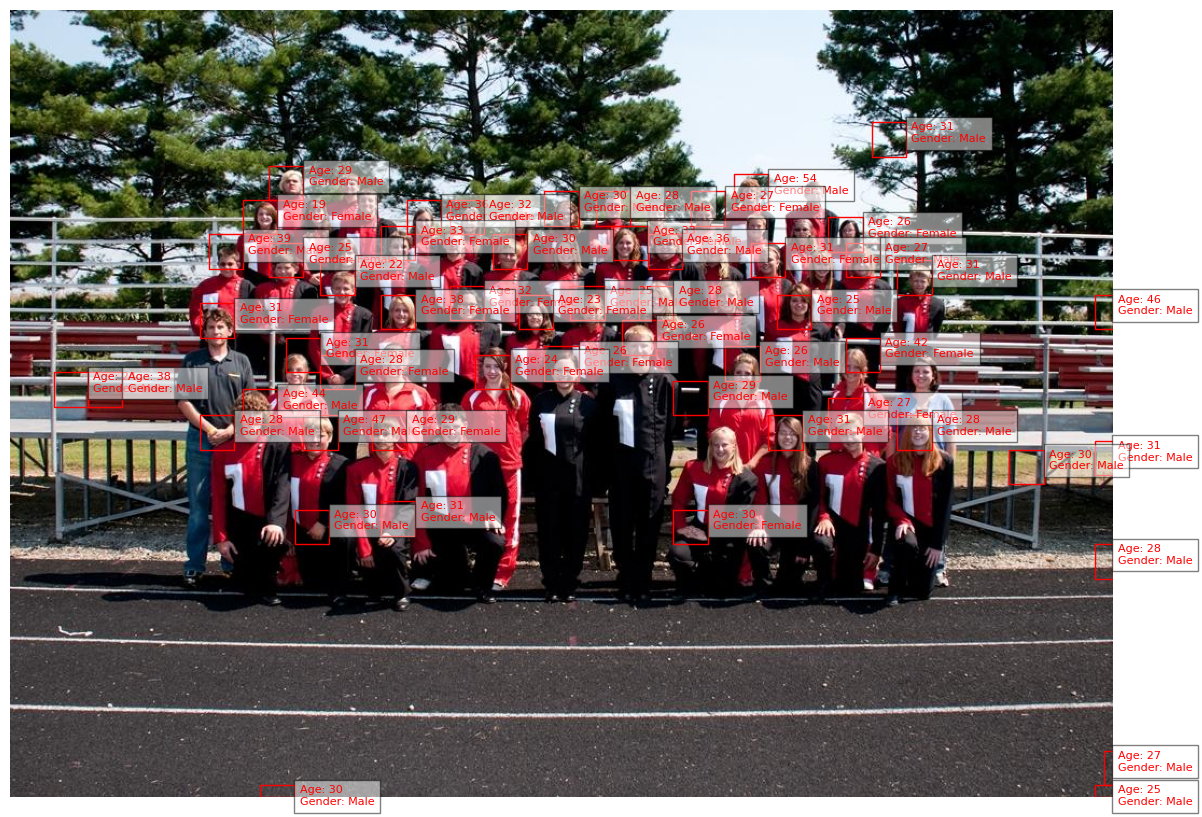

In [ ]:
display_image_with_boxes(tensor_img, pred_boxes)